# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.11.0 tensorflow-gpu==2.11.0 opencv-python matplotlib

## 1.2 Import Dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2022-12-02 20:13:01.401680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 20:13:01.951901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moranguinho/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-02 20:13:01.951930: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 20:13:03.718698: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; d

## 1.3 Set GPU Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [18]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [126]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

qt.qpa.xcb: QXcbConnection: XCB error: 148 (Unknown), sequence: 27475, resource id: 0, major code: 140 (Unknown), minor code: 20


In [ ]:
plt.imshow(frame)

# 2.x NEW - Data Augmentation

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [ ]:
import os
import uuid

In [ ]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [19]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [84]:
dir_test = anchor.as_numpy_iterator()

In [85]:
print(dir_test.next())

b'data/anchor/1bb1c687-7194-11ed-af62-f5ebfc41c5f4.jpg'


## 3.2 Preprocessing - Scale and Resize

In [27]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [91]:
img = preprocess('data/anchor/1bb1c687-7194-11ed-af62-f5ebfc41c5f4.jpg')

In [96]:
img.numpy().max()

0.8833333

In [93]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
exampple = samples.next()

In [25]:
exampple

(b'data/anchor/13d37d58-7194-11ed-af62-f5ebfc41c5f4.jpg',
 b'data/positive/f3a3978d-7193-11ed-af62-f5ebfc41c5f4.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [28]:
res = preprocess_twin(*exampple)

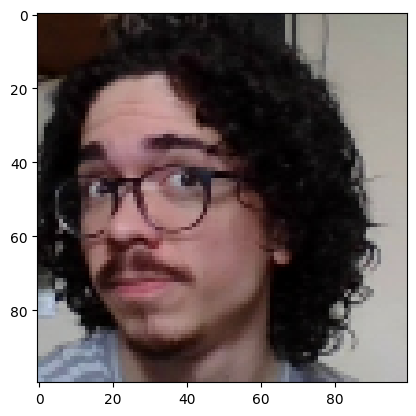

In [29]:
plt.imshow(res[1])

In [30]:
res[2]

1.0

In [31]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [32]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [110]:
inp = Input(shape=(100,100,3), name='input_image')

In [111]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [112]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [113]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [114]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [117]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [118]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [119]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [120]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [121]:
embedding = make_embedding()

In [122]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [11]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [124]:
l1 = L1Dist()

In [125]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [127]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [128]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [129]:
siamese_layer = L1Dist()

In [130]:
distances = siamese_layer(inp_embedding, val_embedding)

In [131]:
classifier = Dense(1, activation='sigmoid')(distances)

In [132]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [133]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [134]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [135]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [136]:
siamese_model = make_siamese_model()

In [137]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [138]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [139]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [140]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [141]:
test_batch = train_data.as_numpy_iterator()

In [142]:
batch_1 = test_batch.next()

In [143]:
X = batch_1[:2]

In [144]:
y = batch_1[2]

In [145]:
y

array([1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

In [146]:
tf.losses.BinaryCrossentropy??

In [147]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [148]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [149]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [150]:
EPOCHS = 50

In [151]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 597s 22s/step
0.13598634 0.7203792 0.9806452

 Epoch 2/50
27/27 [==============================] - 495s 18s/step
0.06882131 0.9951691 0.9951691

 Epoch 3/50
27/27 [==============================] - 503s 19s/step
0.033816207 0.9950739 0.9950739

 Epoch 4/50
27/27 [==============================] - 505s 19s/step
0.008609338 1.0 1.0

 Epoch 5/50
27/27 [==============================] - 506s 19s/step
0.04316514 1.0 1.0

 Epoch 6/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 513s 19s/step
0.0024069943 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 511s 19s/step
8.360393e-05 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 508s 19s/step
0.011251565 1.0 0.9953052

 Epoch 9/50
27/27 [==============================] - 505s 19s/step
0.0001971038 1.0 1.0

 Epoch 10/50
27/27 [==============================] - 506s 19s/step
0.00076168915 1.0 1.0

 Epoch 11/50
27/27 [==============================] - 509s 19s/step
9.1852155e-05 1.0 1.0

 Epoch 12/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 513s 19s/step
4.3200424e-05 1.0 1.0

 Epoch 13/50
27/27 [==============================] - 506s 19s/step
7.882814e-06 1.0 1.0

 Epoch 14/50
27/27 [==============================] - 508s 19s/step
3.1338204e-05 1.0 1.0

 Epoch 15/50
27/27 [==============================] - 509s 19s/step
0.00065610494 1.0 1.0

 Epoch 16/50
27/27 [==============================] - 506s 19s/step
1.151873e-05 1.0 1.0

 Epoch 17/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 503s 19s/step
0.00044579874 1.0 1.0

 Epoch 18/50
27/27 [==============================] - 505s 19s/step
0.00013012838 1.0 1.0

 Epoch 19/50
27/27 [==============================] - 503s 19s/step
0.00019929775 1.0 1.0

 Epoch 20/50
27/27 [==============================] - 507s 19s/step
1.4230939e-05 1.0 1.0

 Epoch 21/50
27/27 [==============================] - 505s 19s/step
1.0877862e-06 1.0 1.0

 Epoch 22/50
27/27 [==============================] - 503s 19s/step
2.0861629e-07 1.0 1.0

 Epoch 23/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 499s 19s/step
3.9073657e-05 1.0 1.0

 Epoch 24/50
27/27 [==============================] - 511s 19s/step
2.7642716e-05 1.0 1.0

 Epoch 25/50
27/27 [==============================] - 506s 19s/step
0.00018850973 1.0 1.0

 Epoch 26/50
27/27 [==============================] - 507s 19s/step
0.00029475454 1.0 1.0

 Epoch 27/50
27/27 [==============================] - 506s 19s/step
7.721438e-05 1.0 1.0

 Epoch 28/50
27/27 [==============================] - 507s 19s/step
6.4075016e-07 1.0 1.0

 Epoch 29/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 505s 19s/step
8.210654e-06 1.0 1.0

 Epoch 30/50
27/27 [==============================] - 506s 19s/step
4.1100775e-05 1.0 1.0

 Epoch 31/50
27/27 [==============================] - 505s 19s/step
7.74861e-07 1.0 1.0

 Epoch 32/50
27/27 [==============================] - 506s 19s/step
2.086163e-07 1.0 1.0

 Epoch 33/50
27/27 [==============================] - 505s 19s/step
1.1920932e-07 1.0 1.0

 Epoch 34/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 506s 19s/step
1.4901161e-08 1.0 1.0

 Epoch 35/50
27/27 [==============================] - 507s 19s/step
5.0663976e-07 1.0 1.0

 Epoch 36/50
27/27 [==============================] - 509s 19s/step
8.732222e-06 1.0 1.0

 Epoch 37/50
27/27 [==============================] - 504s 19s/step
5.1354662e-05 1.0 1.0

 Epoch 38/50
27/27 [==============================] - 506s 19s/step
4.4703775e-06 1.0 1.0

 Epoch 39/50
27/27 [==============================] - 505s 19s/step
2.1755773e-06 1.0 1.0

 Epoch 40/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 509s 19s/step
8.955758e-06 1.0 1.0

 Epoch 41/50
27/27 [==============================] - 507s 19s/step
7.689091e-06 1.0 1.0

 Epoch 42/50
27/27 [==============================] - 507s 19s/step
1.7881399e-07 1.0 1.0

 Epoch 43/50
27/27 [==============================] - 506s 19s/step
2.086163e-07 1.0 1.0

 Epoch 44/50
27/27 [==============================] - 506s 19s/step
6.529014e-05 1.0 1.0

 Epoch 45/50
27/27 [==============================] - 505s 19s/step
1.9371515e-07 1.0 1.0

 Epoch 46/50
1/1 [==============================] - 1s 1s/step


27/27 [==============================] - 506s 19s/step
6.154225e-06 1.0 1.0

 Epoch 47/50
27/27 [==============================] - 505s 19s/step
7.0035526e-07 1.0 1.0

 Epoch 48/50
27/27 [==============================] - 506s 19s/step
3.7700106e-06 1.0 1.0

 Epoch 49/50
27/27 [==============================] - 506s 19s/step
1.1697685e-05 1.0 1.0

 Epoch 50/50
27/27 [==============================] - 505s 19s/step
0.0 1.0 1.0


# 6. Evaluate Model

## 6.1 Import Metrics

In [35]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [90]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [91]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


In [92]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]

In [93]:
y_true

array([0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [94]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [95]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [42]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 370ms/step
1.0 0.9782609


## 6.4 Viz Results

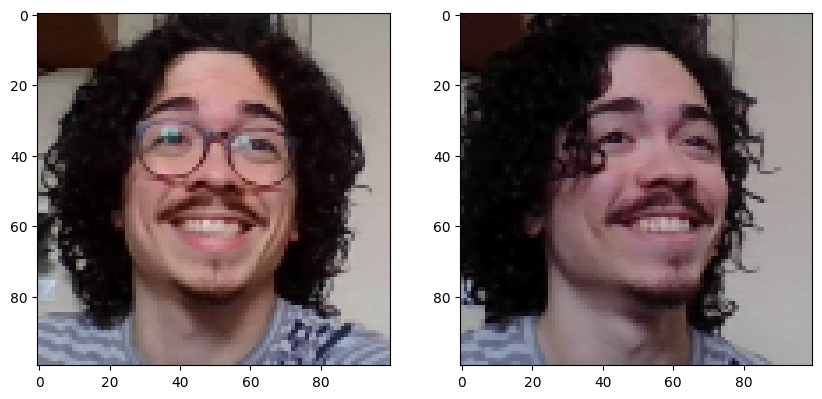

In [98]:
# Set plot size 
plt.figure(figsize=(10,8))

image_index = 1

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[image_index])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[image_index])

# Renders cleanly
plt.show()

# 7. Save Model

In [161]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [12]:
L1Dist

__main__.L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

In [16]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)

In [71]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [99]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 295ms/step
True
1/1 [==============================] - 0s 261ms/step
False
